# Introduction

LSTMを用いた深層学習について、  
複数の時系列データで、各時系列データが複数属性を持つデータを扱う。


# ライブラリの読み込み

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed

# データの作成

データ数は6, 各データは3次元

In [2]:
def make_random_data(length=100):
    yRange = 100
    zRange = 10

    y = 1.0 + np.random.choice(yRange, length)
    z = 1.0 + np.random.choice(zRange, length)
    x = np.random.rand(length)

    # xの値がy, zで決定される
    for t in range(3, length):
        x[t]  = y[t-1] * z[t-2] + y[t-2] + z[t-1]

    data = np.vstack([x, y, z]).swapaxes(0, 1)
    return data

def generate_data(num=6):
    data = []
    for idx in range(num):
        data.append(make_random_data(100))
    return np.array(data)

data = generate_data(6)
print(data.shape)

(6, 100, 3)


In [3]:
def show_graph(data, label, color="b"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.plot(range(len(data)), data, color=color, label=label)
    plt.legend(loc='upper right')
    plt.show()

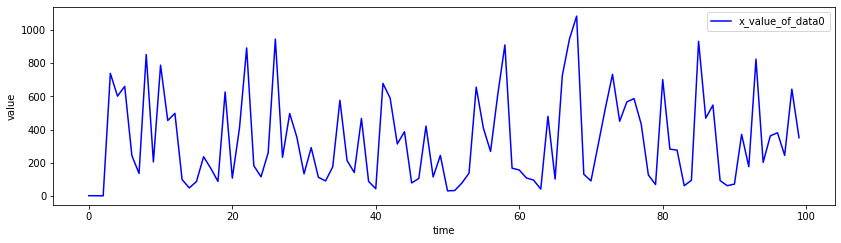

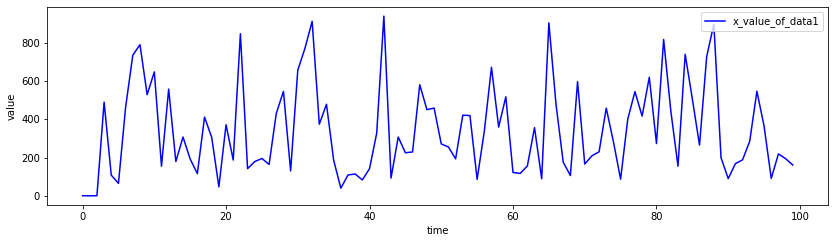

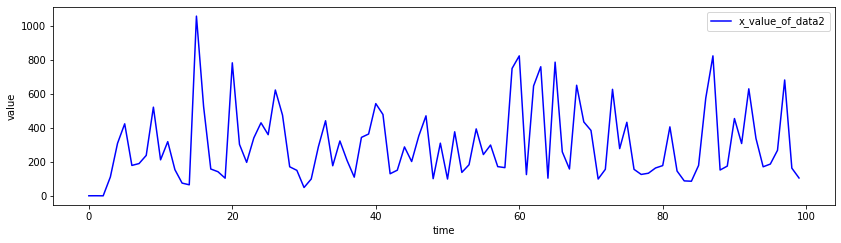

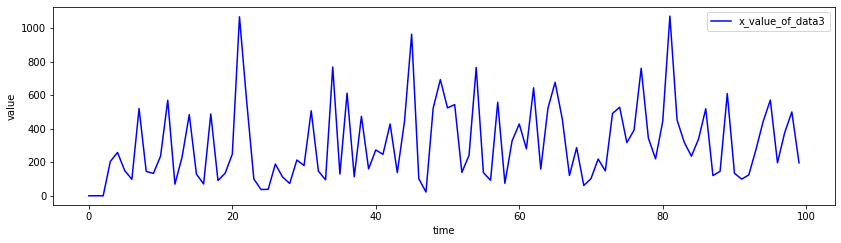

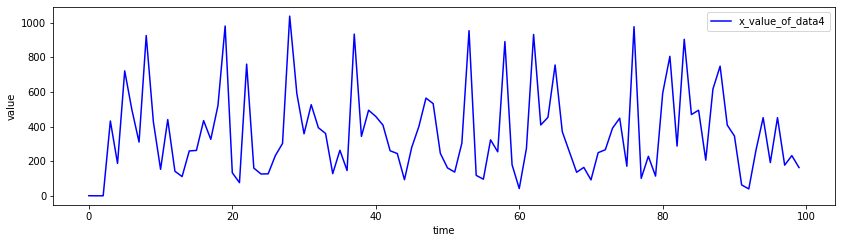

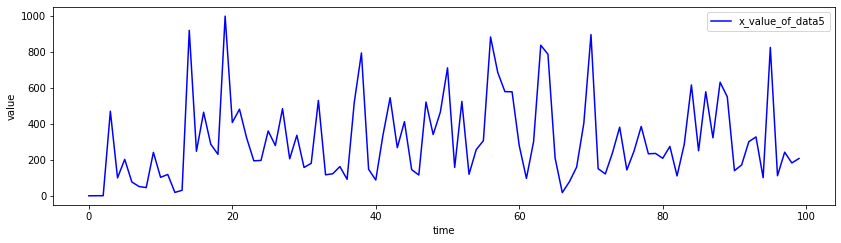

In [4]:
for idx in range(len(data)):
    show_graph(data[idx, :, 0], 'x_value_of_data{}'.format(idx))

# データの分割
- 学習データ (前半70%)
- テストデータ (残り後半30%)

In [5]:
train_rate = 0.7
data_length = data.shape[1]
train_size = int(data_length * train_rate)
train, test = data[:, :train_size, :], data[:, train_size:, :]
print(train.shape)
print(test.shape)

(6, 70, 3)
(6, 30, 3)


# 前処理
- データのスケーリング
- データの各行に過去データ行を追加
- LSTMのインプットデータに整形

In [6]:
# スケーリング
def transform_data(data: np.array, inverse_option: bool, scaler: object, fit: bool=True):
    # x, y, zのそれぞれでスケーリング
    orig_shape = data.shape
    data = data.reshape(-1, data.shape[-1])
    if inverse_option is True:
        data = scaler.inverse_transform(data)
    else:
        if fit:
            scaler.fit(data)
        data = scaler.transform(data)
    return data.reshape(orig_shape)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaling = transform_data(train, inverse_option=False, scaler=scaler)
test_scaling = transform_data(test, inverse_option=False, scaler=scaler, fit=False)

In [7]:
print(train_scaling.shape)
print(test_scaling.shape)

(6, 70, 3)
(6, 30, 3)


In [8]:
print(train_scaling[0, :5])
print(test_scaling[0, :5])

[[6.94300555e-04 5.15151515e-01 5.55555556e-01]
 [4.72881226e-04 7.47474747e-01 6.66666667e-01]
 [6.12624175e-05 9.39393939e-01 5.55555556e-01]
 [6.81086464e-01 8.28282828e-01 1.00000000e+00]
 [5.54811451e-01 5.65656566e-01 7.77777778e-01]]
[[0.08289316 0.3030303  0.66666667]
 [0.28382712 0.6969697  0.66666667]
 [0.48660451 0.93939394 0.44444444]
 [0.67555617 0.6969697  0.55555556]
 [0.41471071 0.81818182 0.44444444]]


In [9]:
# データの各行に過去データ行を追加
def load_past_data(data, n_prev=1):
    df_list = list()
    for d in data:
        # pandasに変換
        columns = ['col{}'.format(idx) for idx in range(d.shape[-1])]
        df = pd.DataFrame(d, columns=columns)
        # 過去データを取得
        for prev in range(1, n_prev + 1):
            past_columns = ['{}_t-{}'.format(colname, prev) for colname in columns]
            past_df = df[columns].shift(prev)
            past_df.rename(columns=dict(zip(past_df.columns, past_columns)), inplace=True)
            df = pd.concat([df, past_df], axis=1)
        # 過去データがない部分を削除
        df = df.drop(range(n_prev))
        df_list.append(df)
    return df_list

prev_length = 2
train_scaling_with_past = load_past_data(train_scaling, prev_length)
test_scaling_with_past = load_past_data(test_scaling, prev_length)

In [10]:
print(train_scaling_with_past[0].shape)
print(train_scaling_with_past[0][:5])

(68, 9)
       col0      col1      col2  col0_t-1  col1_t-1  col2_t-1  col0_t-2  \
2  0.000061  0.939394  0.555556  0.000473  0.747475  0.666667  0.000694   
3  0.681086  0.828283  1.000000  0.000061  0.939394  0.555556  0.000473   
4  0.554811  0.565657  0.777778  0.681086  0.828283  1.000000  0.000061   
5  0.609193  0.222222  0.111111  0.554811  0.565657  0.777778  0.681086   
6  0.223916  0.515152  0.777778  0.609193  0.222222  0.111111  0.554811   

   col1_t-2  col2_t-2  
2  0.515152  0.555556  
3  0.747475  0.666667  
4  0.939394  0.555556  
5  0.828283  1.000000  
6  0.565657  0.777778  


In [11]:
print(test_scaling_with_past[0].shape)
print(train_scaling_with_past[0][:5])

(28, 9)
       col0      col1      col2  col0_t-1  col1_t-1  col2_t-1  col0_t-2  \
2  0.000061  0.939394  0.555556  0.000473  0.747475  0.666667  0.000694   
3  0.681086  0.828283  1.000000  0.000061  0.939394  0.555556  0.000473   
4  0.554811  0.565657  0.777778  0.681086  0.828283  1.000000  0.000061   
5  0.609193  0.222222  0.111111  0.554811  0.565657  0.777778  0.681086   
6  0.223916  0.515152  0.777778  0.609193  0.222222  0.111111  0.554811   

   col1_t-2  col2_t-2  
2  0.515152  0.555556  
3  0.747475  0.666667  
4  0.939394  0.555556  
5  0.828283  1.000000  
6  0.565657  0.777778  


In [12]:
# numpyオブジェクトに変換

X_need_cols = ['col0_t-1', 'col1_t-1', 'col2_t-1', 'col0_t-2', 'col1_t-2', 'col2_t-2']
Y_need_cols = ['col0']

# 必要カラムのみ抽出したリストを作成
need_col_df_list = [d[X_need_cols] for d in train_scaling_with_past]
org_shape = need_col_df_list[0].shape
X_train = np.vstack(need_col_df_list).reshape((len(need_col_df_list),) + org_shape)

need_col_df_list = [d[Y_need_cols] for d in train_scaling_with_past]
org_shape = need_col_df_list[0].shape
Y_train = np.vstack(need_col_df_list).reshape((len(need_col_df_list),) + org_shape)

need_col_df_list = [d[X_need_cols] for d in test_scaling_with_past]
org_shape = need_col_df_list[0].shape
X_test = np.vstack(need_col_df_list).reshape((len(need_col_df_list),) + org_shape)

need_col_df_list = [d[Y_need_cols] for d in test_scaling_with_past]
org_shape = need_col_df_list[0].shape
Y_test = np.vstack(need_col_df_list).reshape((len(need_col_df_list),) + org_shape)

In [13]:
print(X_train.shape)
print(X_train[0, :5])

(6, 68, 6)
[[4.72881226e-04 7.47474747e-01 6.66666667e-01 6.94300555e-04
  5.15151515e-01 5.55555556e-01]
 [6.12624175e-05 9.39393939e-01 5.55555556e-01 4.72881226e-04
  7.47474747e-01 6.66666667e-01]
 [6.81086464e-01 8.28282828e-01 1.00000000e+00 6.12624175e-05
  9.39393939e-01 5.55555556e-01]
 [5.54811451e-01 5.65656566e-01 7.77777778e-01 6.81086464e-01
  8.28282828e-01 1.00000000e+00]
 [6.09192661e-01 2.22222222e-01 1.11111111e-01 5.54811451e-01
  5.65656566e-01 7.77777778e-01]]


In [14]:
print(Y_train.shape)
print(Y_train[0, :5])

(6, 68, 1)
[[6.12624175e-05]
 [6.81086464e-01]
 [5.54811451e-01]
 [6.09192661e-01]
 [2.23915615e-01]]


In [15]:
print(X_test.shape)
print(X_train[0, :5])

(6, 28, 6)
[[4.72881226e-04 7.47474747e-01 6.66666667e-01 6.94300555e-04
  5.15151515e-01 5.55555556e-01]
 [6.12624175e-05 9.39393939e-01 5.55555556e-01 4.72881226e-04
  7.47474747e-01 6.66666667e-01]
 [6.81086464e-01 8.28282828e-01 1.00000000e+00 6.12624175e-05
  9.39393939e-01 5.55555556e-01]
 [5.54811451e-01 5.65656566e-01 7.77777778e-01 6.81086464e-01
  8.28282828e-01 1.00000000e+00]
 [6.09192661e-01 2.22222222e-01 1.11111111e-01 5.54811451e-01
  5.65656566e-01 7.77777778e-01]]


In [16]:
print(Y_test.shape)
print(Y_test[0, :5])

(6, 28, 1)
[[0.48660451]
 [0.67555617]
 [0.41471071]
 [0.52255141]
 [0.54098572]]


#### この時点でデータは
- 元データ => [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3], ..., [x100, y100, z100]] というデータが6個  
<br>
- X_train => [[x2, y2, z2, x1, y1, z1], [x3, y3, z3, x2, y2, z2], ... [x100, y100, z100, x99, y99, z99]] × 6個  
- Y_train => [[x3], [x4], [x5], [x6], ...] × 6個  
という形になっている(scalingは無視)  
つまり X_train[n, m, :] から Y_train[n, m, :] が決定している

In [17]:
# LSTMのインプットデータへ整形
def create_dataset(data, batch_size, length):
    if data.shape[0] % batch_size != 0:
        raise ValueError('バッチサイズが不正です。')
    else:
        batch_num = data.shape[0] / batch_size

    if data.shape[1] % length != 0:
        raise ValueError('レングスが不正です。')
    else:
        split_num = data.shape[1] / length

    batch_list = np.split(data, batch_num, axis=0)
    split_list = [np.concatenate(np.split(batch, split_num, axis=1)) for batch in batch_list]
    data = np.concatenate(split_list)
    
    return data

batch_size = 3
X_train_dataset = create_dataset(X_train, batch_size, prev_length)
Y_train_dataset = create_dataset(Y_train, batch_size, prev_length)
X_test_dataset = create_dataset(X_test, batch_size, prev_length)

In [18]:
print(X_train_dataset.shape)
print(Y_train_dataset.shape)
print(X_test_dataset.shape)

(204, 2, 6)
(204, 2, 1)
(84, 2, 6)


#### この時点でデータは
- 元データ =>  
[[x1_1, y1_1, z1_1], [x1_2, y1_2, z1_2], [x1_3, y1_3, z1_3], ..., [x1_100, y1_100, z1_100]]  (データ1)  
[[x2_1, y2_1, z2_1], [x2_2, y2_2, z2_2], [x2_3, y2_3, z2_3], ..., [x2_100, y2_100, z2_100]]  (データ2)  
...  
[[x6_1, y6_1, z6_1], [x6_2, y6_2, z6_2], [x6_3, y6_3, z6_3], ..., [x6_100, y6_100, z6_100]]  (データ6)  
  
  
- X_train_dataset =>  
[[x1_2, y1_2, z1_2, x1_1, y1_1, z1_1], [x1_3, y1_3, z1_3, x1_2, y1_2, z1_2]],  
[[x2_2, y2_2, z2_2, x2_1, y2_1, z2_1], [x2_3, y2_3, z2_3, x2_2, y2_2, z2_2]],  
[[x3_2, y3_2, z3_2, x2_1, y2_1, z2_1], [x3_3, y3_3, z3_3, x3_2, y3_2, z3_2]],  
== ここまでで1バッチ ==  
[[x1_4, y1_4, z1_4, x1_3, y1_3, z1_3], [x1_5, y1_5, z1_5, x1_4, y1_4, z1_4]],  
[[x2_4, y2_4, z2_4, x2_3, y2_3, z2_3], [x2_5, y2_5, z2_5, x2_4, y2_4, z2_4]],  
[[x3_4, y3_4, z3_4, x2_3, y2_3, z2_3], [x3_5, y3_5, z3_5, x3_4, y3_4, z3_4]],  
== ここまでで1バッチ ==  
...
データ1, 2, 3が終わったら、データ4, 5, 6で同様のデータが続く

- Y_train_dataset =>  
[[x1_3], [x1_4]],  
[[x2_3], [x2_4]],
[[x3_3], [x3_4]],
== ここまでで1バッチ ==  
... 
という形になっている(scalingは無視)  

# モデル作成

In [19]:
def create_model(batch_size, input_dim, output_dim, hidden_neurons, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(hidden_neurons, batch_input_shape=(batch_size, None, input_dim), return_sequences=True, stateful=True))
    model.add(TimeDistributed(Dense(output_dim, activation='linear')))
    print(model.summary())

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

input_dim = X_train_dataset.shape[2]
output_dim = Y_train_dataset.shape[2]
hidden_neurons = 20
model = create_model(batch_size,
                     input_dim, 
                     output_dim,
                     hidden_neurons)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (3, None, 20)             2160      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
epochs = 100

for i in range(epochs):
    history = model.fit(X_train_dataset, Y_train_dataset, batch_size=batch_size, epochs=1, shuffle=False)
    model.reset_states()

68/68 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 0.0012


# テストデータ検証

In [21]:
pred_test = model.predict(X_test_dataset, batch_size=batch_size)
print(pred_test.shape)

(84, 2, 1)


In [22]:
def reshape_dataset(data, batch_size, org_shape):
    length = data.shape[1]

    # 一度連続で同型のデータでcreate_datasetを実行し、データ順序を調べる
    tmp = np.array(range(data.shape[0] * data.shape[1] * data.shape[2])).reshape(org_shape)
    sample = create_dataset(tmp, batch_size, length)
    order = np.argsort(sample[:, 0, 0])

    data = data[order, :, :].reshape(org_shape)
    return data

target_shape = X_test.shape[:2] + (1,)
Y_pred_test_scaling = reshape_dataset(pred_test, batch_size, target_shape)
print(Y_pred_test_scaling.shape)

(6, 28, 1)


In [23]:
# リバーススケーリングのために、shapeを合わせる
pred_shape = Y_pred_test_scaling.shape
dummy = np.ones((pred_shape[0], pred_shape[1], train.shape[2] - pred_shape[2]))
Y_pred_test_scaling_with_dummy = np.append(Y_pred_test_scaling, dummy, axis=2)

Y_pred_test = transform_data(Y_pred_test_scaling_with_dummy, inverse_option=True, scaler=scaler)[:, :, 0:1]
print(Y_pred_test.shape)

(6, 28, 1)


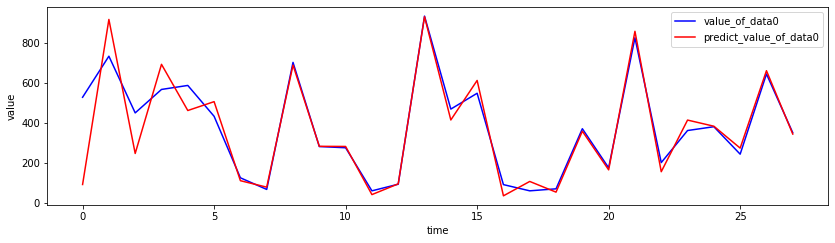

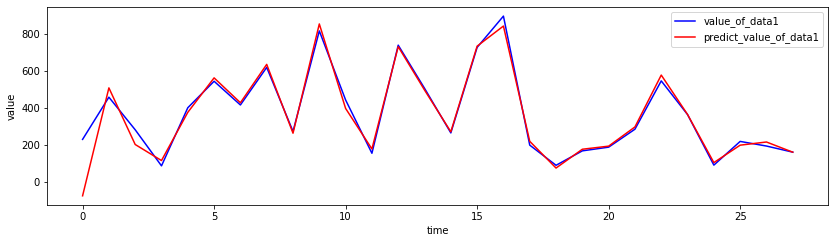

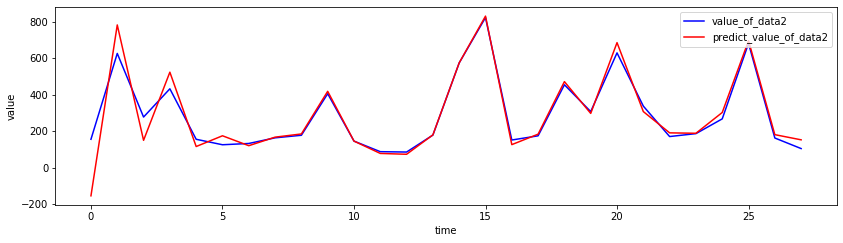

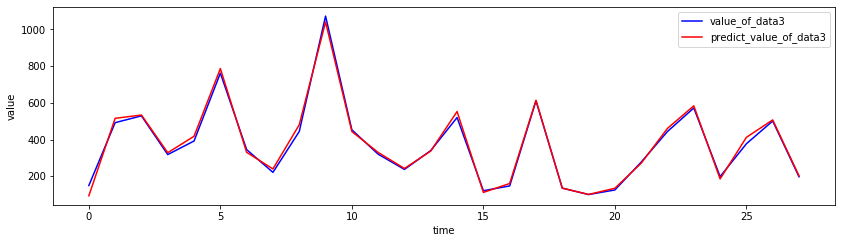

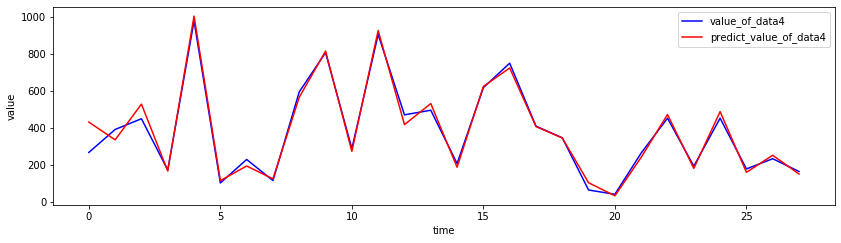

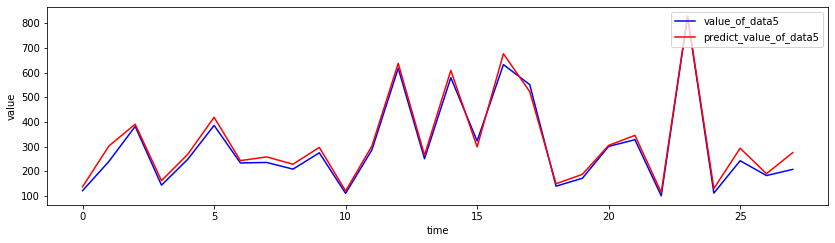

In [24]:
def show_graph_for_two_data(data1, data2, label1, label2, color1="b", color2="r"):
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.plot(range(len(data1)), data1, color=color1, label=label1)
    plt.plot(range(len(data2)), data2, color=color2, label=label2)
    plt.legend(loc='upper right')
    plt.show()

real_data= data[:, -Y_pred_test.shape[1]:, 0:1]

for idx in range(len(Y_test)):
    show_graph_for_two_data(real_data[idx, :, 0], Y_pred_test[idx, :, 0], 'value_of_data{}'.format(idx), 'predict_value_of_data{}'.format(idx))